In [5]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [6]:
shot_path = 'laser_shots'
focus_point_hole_position = 9.8
cam_pos = 18.5
hole_interval = 25 # mm

best_circle_focus = (158, 120)

In [7]:
def filter_bright_range(img: np.ndarray, threshold: int = 100) -> np.ndarray:
    bright_pixels = img > threshold
    # get smallest and largest indices of bright pixels, both in x and y direction
    x_min, x_max = np.min(np.where(bright_pixels)[0]), np.max(np.where(bright_pixels)[0])
    y_min, y_max = np.min(np.where(bright_pixels)[1]), np.max(np.where(bright_pixels)[1])
    return img[x_min:x_max, y_min:y_max]

In [8]:
def get_avg_img(filename: str, cnt: int = 5, base_dir: str = '../laser_shots/100us') -> np.ndarray:
    imgs = []
    for i in range(1, cnt + 1):
        img = cv.imread(f'{base_dir}/{filename}_{i}.png', cv.IMREAD_GRAYSCALE)
        imgs.append(img)
    return np.mean(imgs, axis=0).astype(np.uint8)

In [9]:
def get_row_col_sum(img: np.ndarray) -> (np.ndarray, np.ndarray):
    row_sum = np.sum(img, axis=1)
    col_sum = np.sum(img, axis=0)
    return row_sum, col_sum

def centre_of_mass(img: np.ndarray) -> (int, int):
    row_sum, col_sum = get_row_col_sum(img)
    row_com = np.sum(row_sum * np.arange(row_sum.shape[0])) / np.sum(row_sum)
    col_com = np.sum(col_sum * np.arange(col_sum.shape[0])) / np.sum(col_sum)
    return round(row_com), round(col_com)

def centroid(img: np.ndarray) -> (int, int):
    # row_sum, col_sum = get_row_col_sum(img)
    # # get the arithmatic mean of the indices of the bright pixels
    # row_centroid = np.mean(np.where(row_sum > 0))
    # col_centroid = np.mean(np.where(col_sum > 0))
    # return round(row_centroid), round(col_centroid)
    M = cv.moments(img)
    row_centroid = int(M['m01'] / M['m00'])
    col_centroid = int(M['m10'] / M['m00'])
    return row_centroid, col_centroid

In [10]:
def crop_sqaure(img: np.ndarray) -> (np.ndarray, int):
    center_x, center_y = centre_of_mass(img)
    side_len = min(center_x, center_y, img.shape[0] - center_x, img.shape[1] - center_y)
    res = img[center_x - side_len : center_x + side_len, center_y - side_len : center_y + side_len]
    return res, res.shape[0]

def get_centre_distributions(img: np.ndarray) -> (np.ndarray, np.ndarray):
    squared, sidelen = crop_sqaure(img)
    return squared[sidelen // 2, :], squared[:, sidelen // 2]

In [11]:
def gaussian(x: np.ndarray, mean: float, std: float) -> float:
    return np.exp(-0.5 * ((x - mean) / std)**2) / (std * np.sqrt(2 * np.pi))

def gaussian_approximation_1d(arr: np.ndarray) -> (float, float):
    x = np.arange(arr.shape[0])
    mean = np.sum(x * arr) / np.sum(arr)
    std = np.sqrt(np.sum(arr * (x - mean)**2) / np.sum(arr))
    return mean, std

def gaussian_fit_plot_1d(arr: np.ndarray, mean: float, std: float) -> None:
    x = np.arange(arr.shape[0])
    # first normalize the data
    plt.plot(x, arr, label='Data')
    approx = gaussian(x, mean, std)
    plt.plot(x, approx * np.sum(arr), label='Gaussian approximation')
    plt.legend()
    plt.show()

In [12]:
avg_img = get_avg_img('13h_100us')
# filter pixel value less than 5
avg_img = avg_img * (avg_img > 3)

Centre of mass: (923, 628)


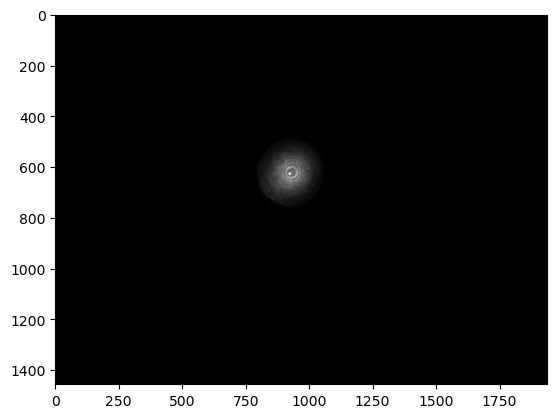

In [13]:
row_com, col_com = centre_of_mass(avg_img)
print(f'Centre of mass: ({col_com}, {row_com})')
# show the centre of mass on the image
to_show = avg_img.copy()
cv.circle(to_show, (int(col_com), int(row_com)), 5, (255, 255, 255), -1)
plt.imshow(to_show, cmap='gray')

Centroid: (923, 627)


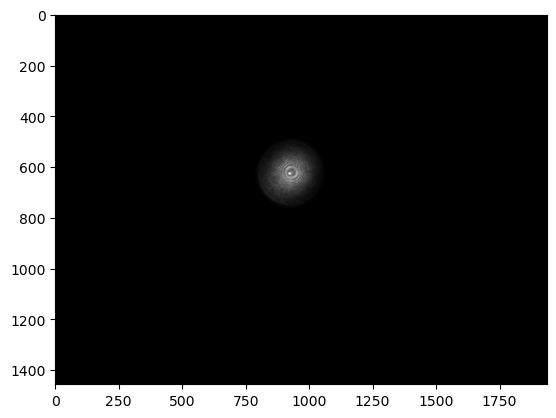

In [14]:
cx, cy = centroid(avg_img)
print(f'Centroid: ({cy}, {cx})')
# show the centroid on the image
to_show = avg_img.copy()
cv.circle(to_show, (int(cy), int(cx)), 5, (255, 255, 255), -1)
plt.imshow(to_show, cmap='gray')

Side length of the square: 1256


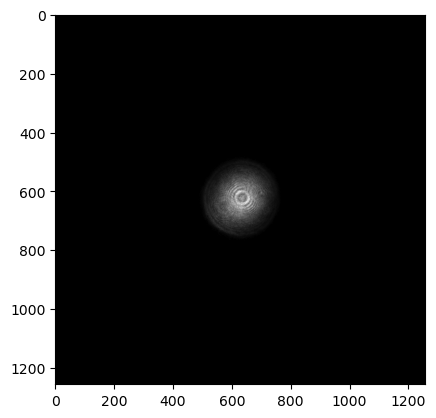

In [15]:
sq_img, sidelen = crop_sqaure(avg_img)
print(f'Side length of the square: {sidelen}')
plt.imshow(sq_img, cmap='gray')

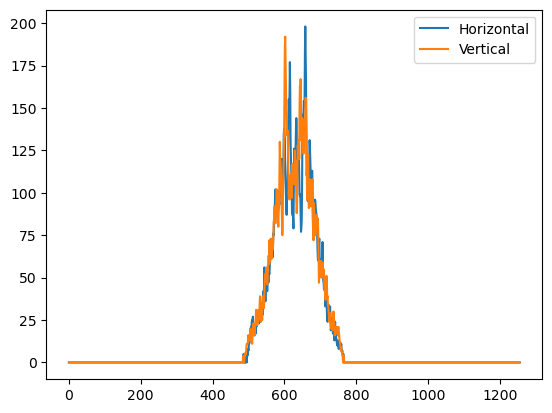

In [16]:
horiz, vert = get_centre_distributions(avg_img)
# plot the horizontal and vertical distributions in one figure
plt.plot(horiz, label='Horizontal')
plt.plot(vert, label='Vertical')
plt.legend()
plt.show()

In [17]:
mean_h, std_h = gaussian_approximation_1d(horiz)
mean_v, std_v = gaussian_approximation_1d(vert)
print(f'Horizontal mean: {mean_h}, std: {std_h}')
print(f'Vertical mean: {mean_v}, std: {std_v}')

Horizontal mean: 629.0479437111378, std: 53.37883100549654
Vertical mean: 628.4951580291582, std: 54.056815508648654


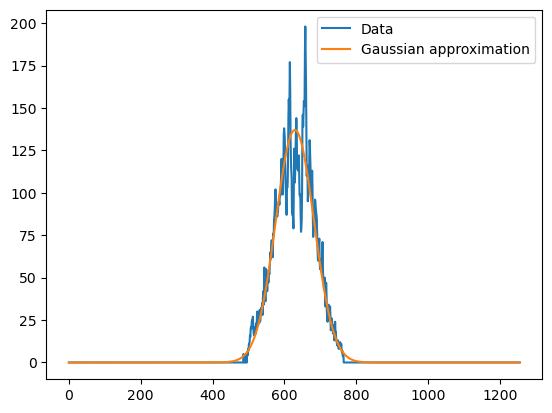

In [18]:
gaussian_fit_plot_1d(horiz, mean_h, std_h)

In [19]:
dist_to_analyze = ['13h', 'focus', '5h', '2h']

In [54]:
avg_imgs = [get_avg_img(f'{dist}_100us') for dist in dist_to_analyze]
avg_imgs = [img * (img > 3) for img in avg_imgs]
distributions_h, distributions_v = [], []
for img in avg_imgs:
    horiz, vert = get_centre_distributions(img)
    distributions_h.append(horiz)
    distributions_v.append(vert)
approx_h, approx_v = [], []
for dist in distributions_h:
    mean, std = gaussian_approximation_1d(dist)
    approx_h.append((mean, std))
for dist in distributions_v:
    mean, std = gaussian_approximation_1d(dist)
    approx_v.append((mean, std))

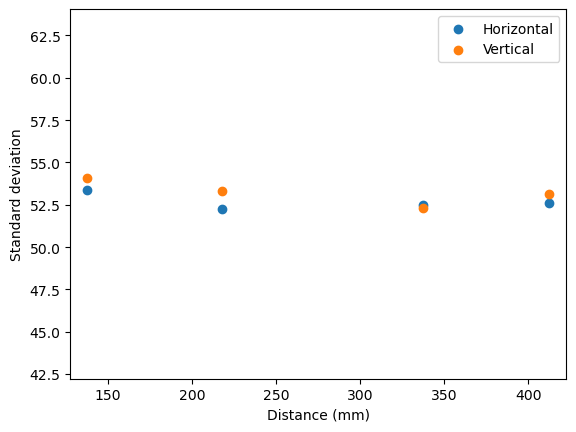

In [55]:
# plot the standard deviation with respect to the distance
dists = []
std_h = [std for _, std in approx_h]
std_v = [std for _, std in approx_v]
for dist in dist_to_analyze:
    if dist == 'focus':
        hole_cnt = focus_point_hole_position
    else:
        hole_cnt = int(dist[:-1])
    dists.append((cam_pos - hole_cnt) * hole_interval)
plt.scatter(dists, std_h, label='Horizontal')
plt.scatter(dists, std_v, label='Vertical')
# set x range from 0 to max distance
plt.xlim(min(dists) - 10, max(dists) + 10)
# set y range from 0 to max standard deviation
plt.ylim(min(min(std_h), min(std_v)) - 10, max(max(std_h), max(std_v)) + 10)
plt.legend()
plt.xlabel('Distance (mm)')
plt.ylabel('Standard deviation')
plt.show()

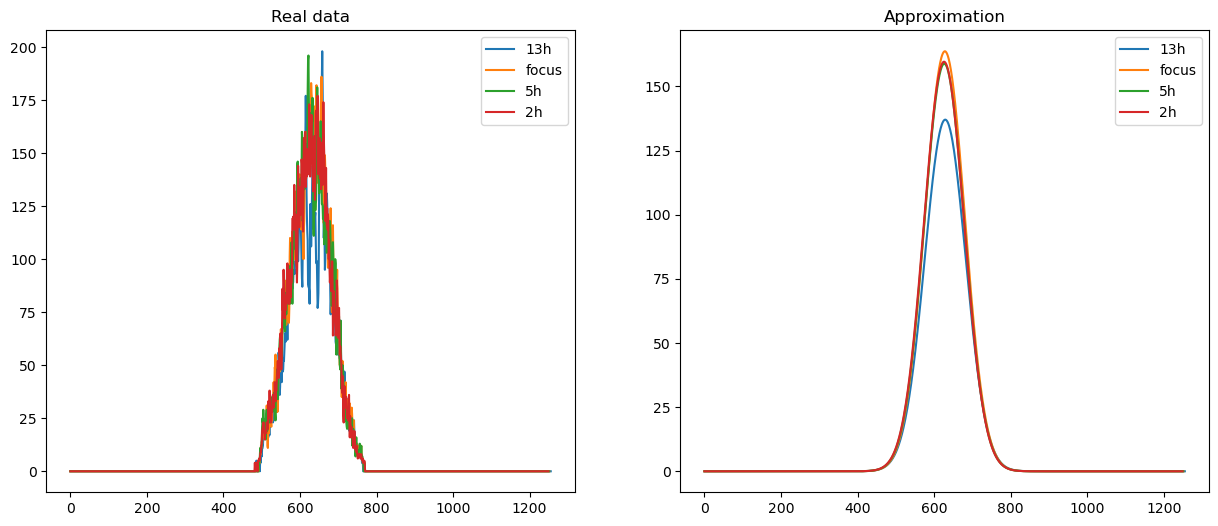

In [56]:
# split the real data and approximation to left and right, for four different cases
# first on horizontal
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for i in range(4):
    # add real data to left 
    axs[0].plot(distributions_h[i], label=f'{dist_to_analyze[i]}')
    # add approximation to right
    mean, std = approx_h[i]
    x = np.arange(distributions_h[i].shape[0])
    axs[1].plot(x, gaussian(x, mean, std) * sum(distributions_h[i]), label=f'{dist_to_analyze[i]}')
axs[0].legend()
axs[1].legend()
# set title 
axs[0].set_title('Real data')
axs[1].set_title('Approximation')
plt.show()

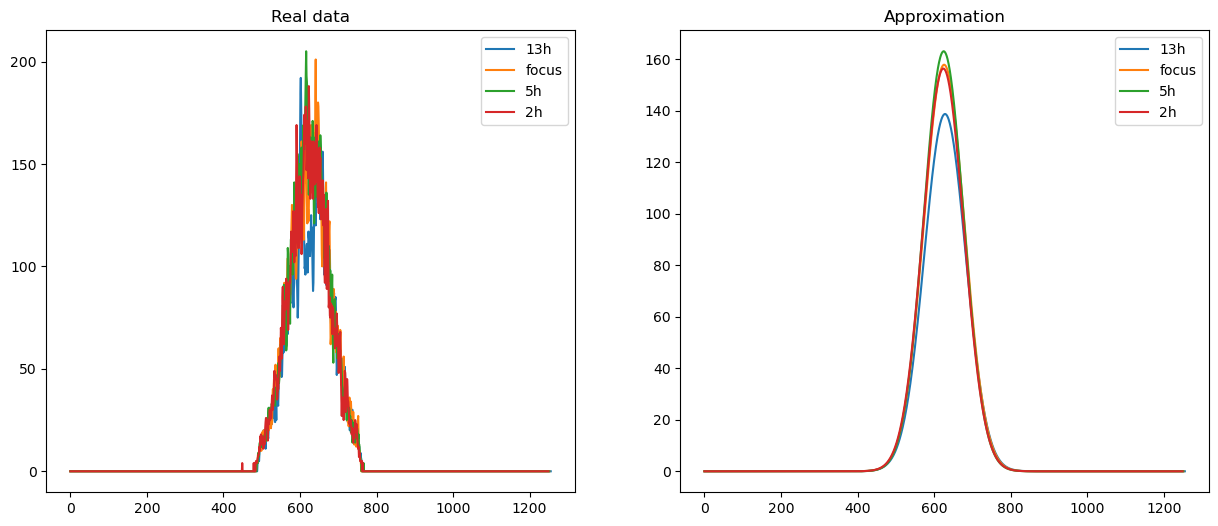

In [57]:
# then for vertical
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for i in range(4):
    # add real data to left 
    axs[0].plot(distributions_v[i], label=f'{dist_to_analyze[i]}')
    # add approximation to right
    mean, std = approx_v[i]
    x = np.arange(distributions_v[i].shape[0])
    axs[1].plot(x, gaussian(x, mean, std) * sum(distributions_v[i]), label=f'{dist_to_analyze[i]}')
axs[0].legend()
axs[1].legend()
# set title
axs[0].set_title('Real data')
axs[1].set_title('Approximation')
plt.show()

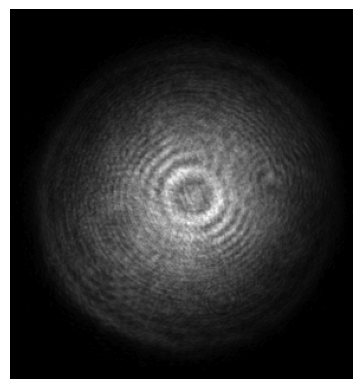

In [42]:
bright_parts = filter_bright_range(avg_img, 3)
plt.axis('off')
plt.imshow(bright_parts, cmap='gray')

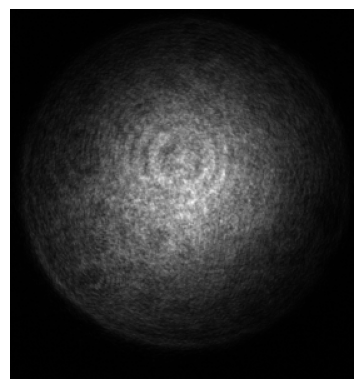

In [181]:
plt.axis('off')
plt.imshow(filter_bright_range(imgs[0], 5), cmap='gray')

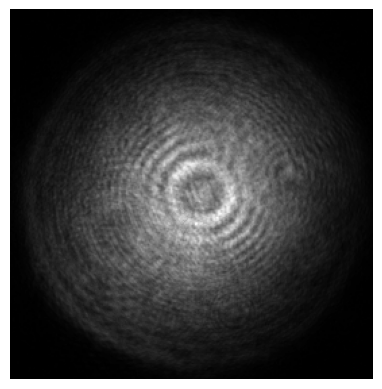

In [182]:
# turn the image into a 8-bit image
bright_parts = cv.normalize(bright_parts, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
plt.axis('off')
plt.imshow(bright_parts, cmap='gray')

In [183]:
gradient_x = cv.Sobel(bright_parts, cv.CV_64F, 1, 0, ksize=5)
gradient_y = cv.Sobel(bright_parts, cv.CV_64F, 0, 1, ksize=5)

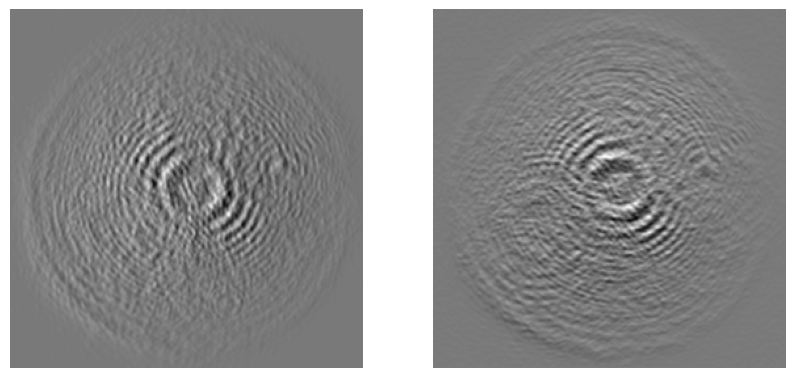

In [184]:
fig = plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(gradient_x, cmap='gray')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(gradient_y, cmap='gray')

In [224]:
center_points = [(136, 143), (120, 138), (128, 140), (128, 140)]

squared_imgs = []
for i, img in enumerate(avg_imgs):
    # get the maximum square from the image using the center point
    

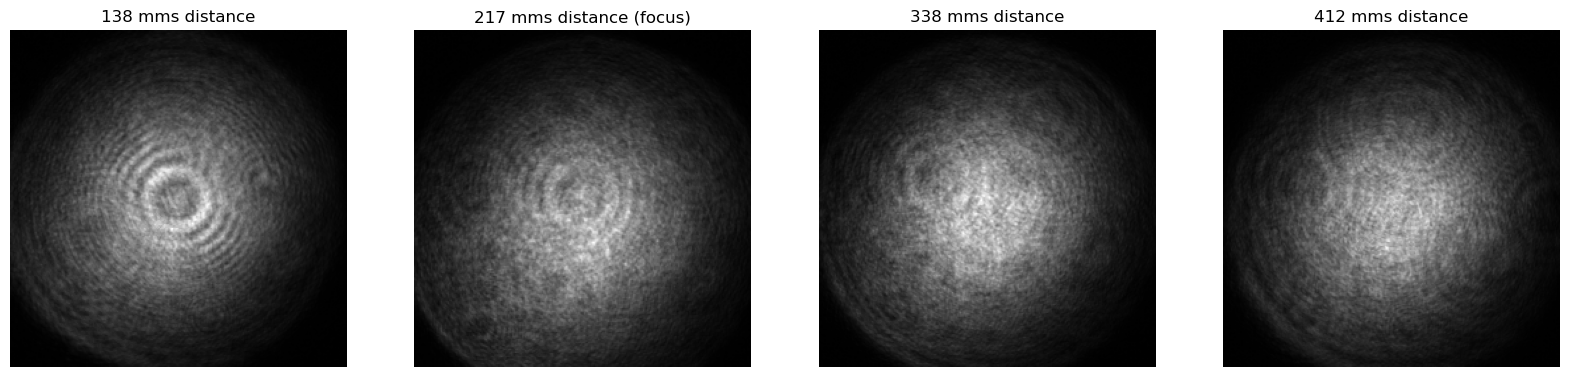

In [226]:
# plot all the images
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, img in enumerate(squared_imgs):
    pos = dist_to_analyze[i]
    if pos == 'focus':
        hole_cnt = 9.8
    else:
        hole_cnt = int(pos[:-1])
    axes[i].axis('off')
    axes[i].imshow(img, cmap='gray')
    title = str(round((cam_pos - hole_cnt) * hole_interval)) + ' mms distance' + (' (focus)' if pos == 'focus' else '')
    axes[i].set_title(title)

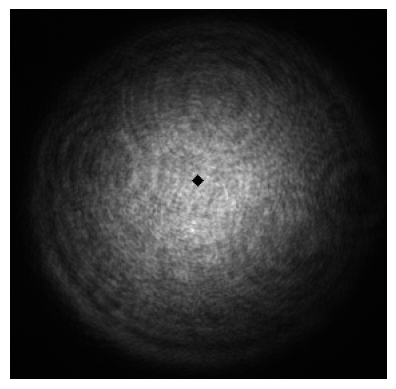

In [207]:
test_x, test_y = 128, 140
to_show = avg_imgs[3].copy()
cv.circle(to_show, (test_y, test_x), 2, (0, 0, 255), 3)
plt.axis('off')
plt.imshow(to_show, cmap='gray')

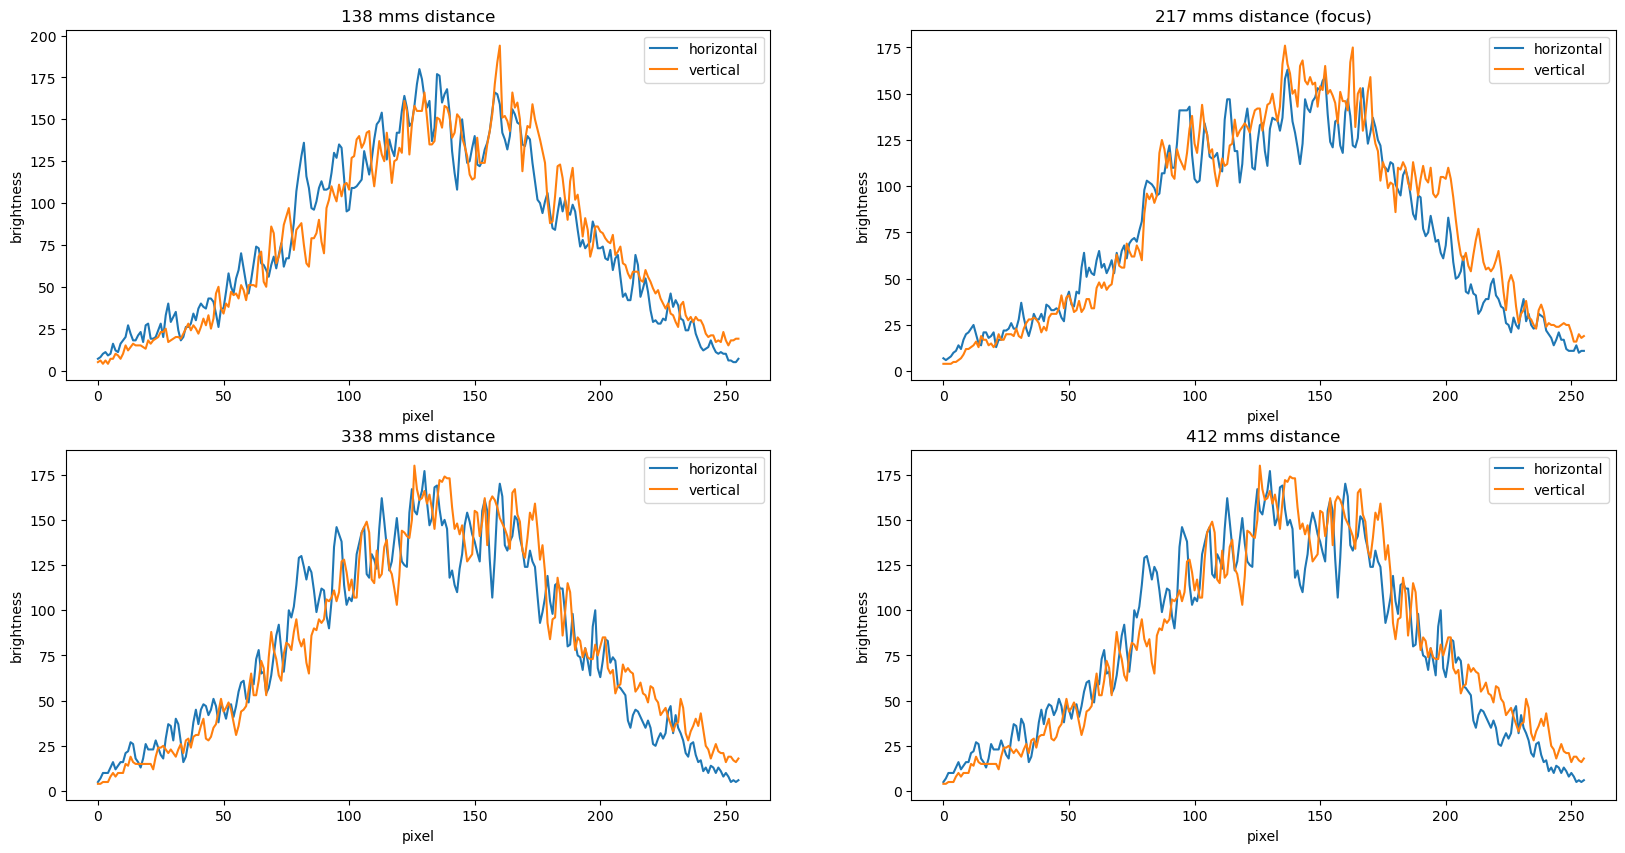

In [229]:
distributions = []
for i, img in enumerate(squared_imgs):
    mid_x, mid_y = img.shape[0] // 2, img.shape[1] // 2
    # get the horizontal and vertical distributions
    horizontal_distribution = square[mid_x]
    vertical_distribution = square[:, mid_y]
    distributions.append((horizontal_distribution, vertical_distribution))
# plot the distributions in 2 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for i, (dist, ax) in enumerate(zip(distributions, axes.flatten())):
    pos = dist_to_analyze[i]
    if pos == 'focus':
        hole_cnt = 9.8
    else:
        hole_cnt = int(pos[:-1])
    ax.plot(dist[0])
    ax.plot(dist[1])
    title = str(round((cam_pos - hole_cnt) * hole_interval)) + ' mms distance' + (' (focus)' if pos == 'focus' else '')
    ax.set_title(title)
    ax.set_xlabel('pixel')
    ax.set_ylabel('brightness')
    ax.legend(['horizontal', 'vertical'])

# store the plot in a file
# plt.savefig('distributions_manual_midpoint.png')

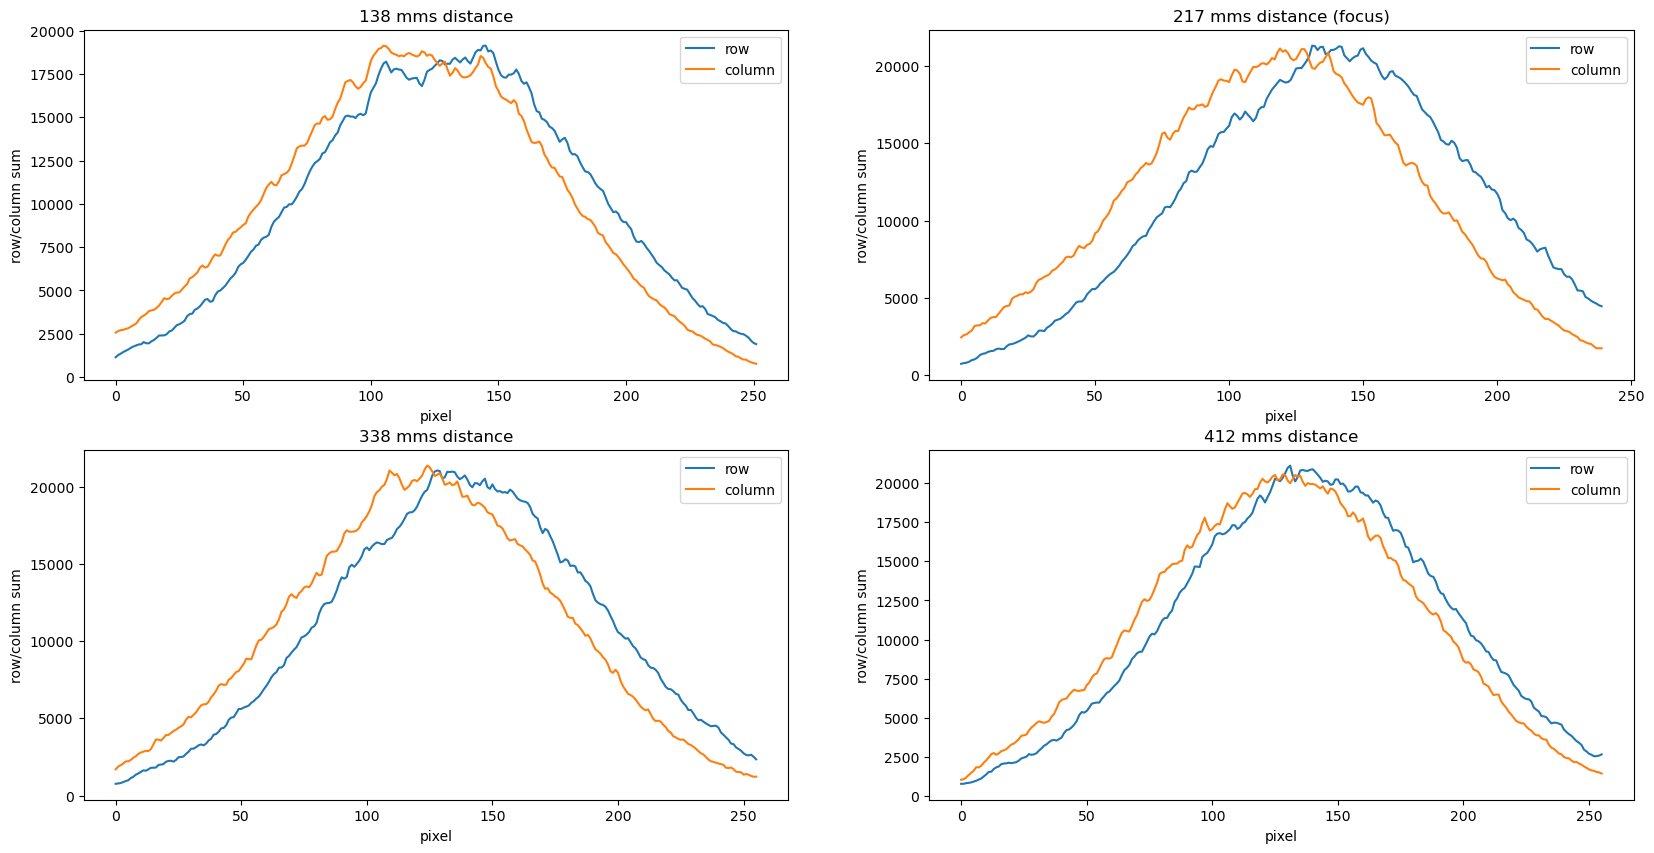

In [230]:
sums = []
for i, img in enumerate(squared_imgs):
    row_sum = np.sum(img, axis=1)
    col_sum = np.sum(img, axis=0)
    sums.append((row_sum, col_sum))
# plot the distributions in 2*2 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for i, (sum_, ax) in enumerate(zip(sums, axes.flatten())):
    pos = dist_to_analyze[i]
    if pos == 'focus':
        hole_cnt = 9.8
    else:
        hole_cnt = int(pos[:-1])
    ax.plot(sum_[0])
    ax.plot(sum_[1])
    title = str(round((cam_pos - hole_cnt) * hole_interval)) + ' mms distance' + (' (focus)' if pos == 'focus' else '')
    ax.set_title(title)
    ax.set_xlabel('pixel')
    ax.set_ylabel('row/column sum')
    ax.legend(['row', 'column'])

In [214]:
arr = np.array([[1,2],[3,4]])
np.sum(arr, axis=0)

array([4, 6])